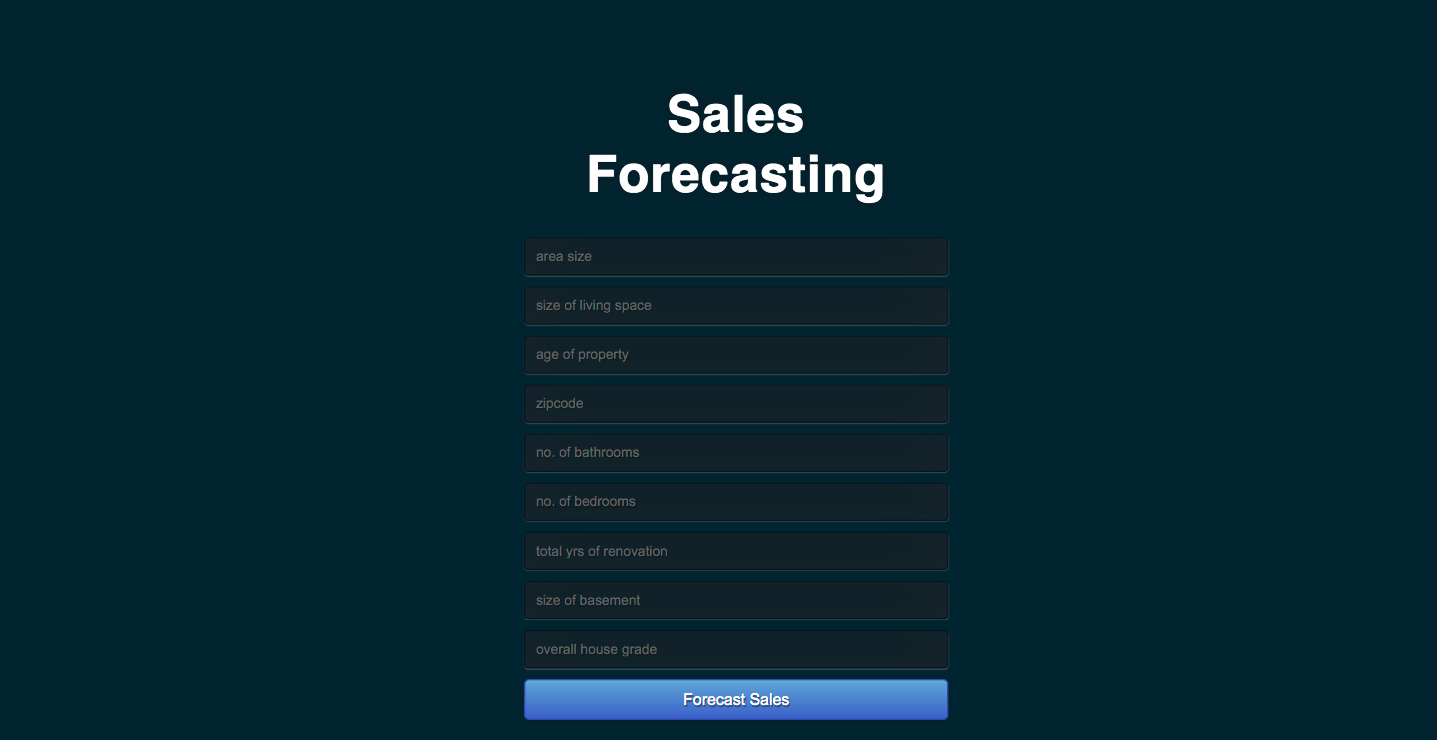

# **Sales Forcast**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge,RANSACRegressor,HuberRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.decomposition import PCA, KernelPCA
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [10]:
data = pd.read_csv('kc_house_data.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


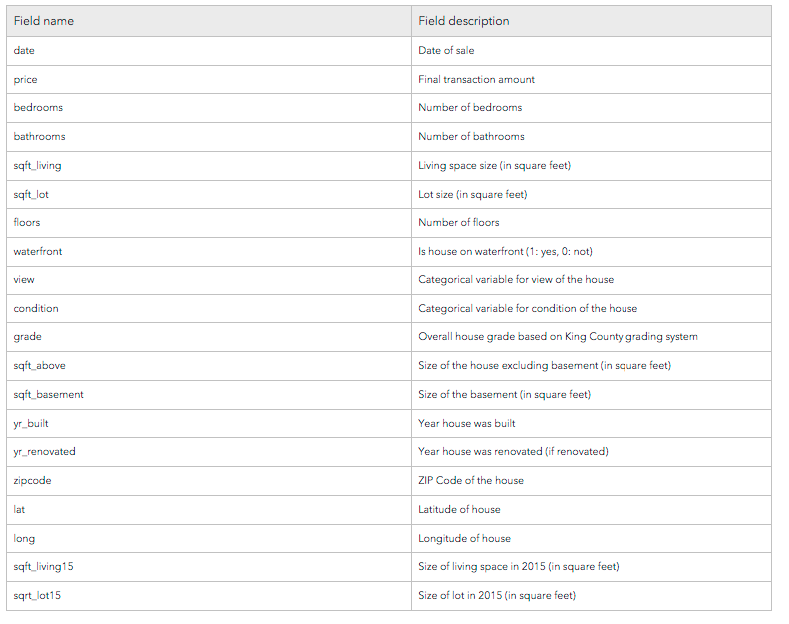

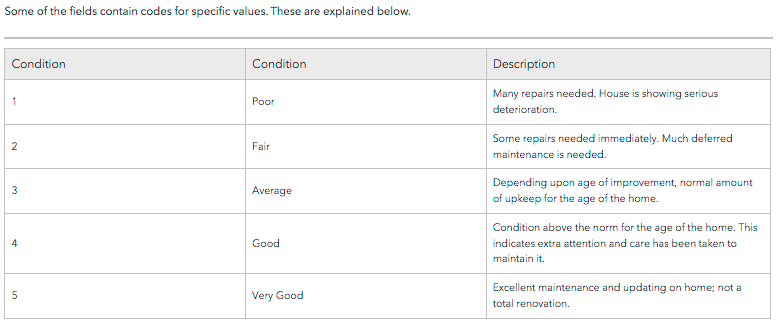

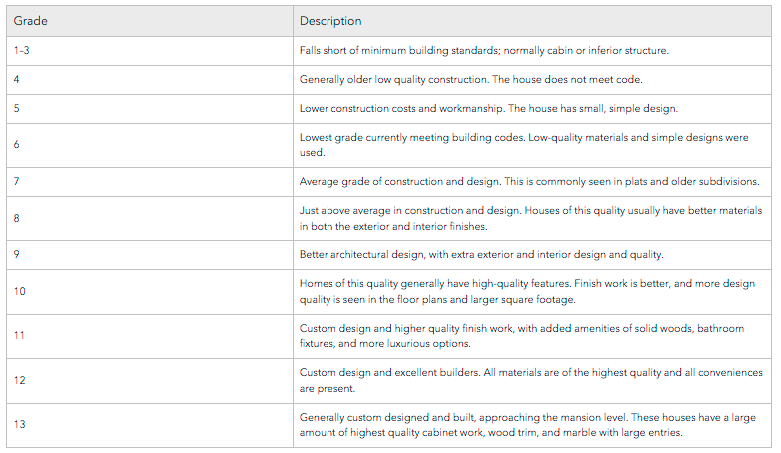

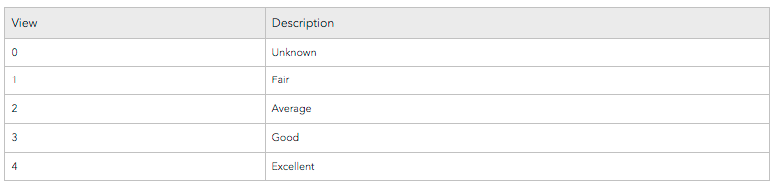

In [11]:
#see the datatype of each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [12]:
data.isnull().any().sum() #you can also add .sum()

1

In [13]:
#fill all the values with 0
data.fillna(0, inplace=True)

### **Feature Creation**

In [14]:
#format the date
d =[]
for i in data['date'].values:
    d.append(i[:4])

data['date'] = d

# convert everything to same datatype
for i in data.columns:
    data[i]=data[i].astype(float)

#make a new column age of the house
data['age'] = 2023 - data['yr_built']

#calculate the total years of renovation
data['renov_age'] = np.abs(data['yr_renovated'] - data['yr_built'])

data['renov_age'] = data.renov_age.apply(lambda x: x if len(str(int(x)))==2 else 0.0)

#remove unwanted columns like yr_built, date, id
data.drop(['id','date', 'yr_built', 'yr_renovated'], axis=1, inplace=True)
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,renov_age
0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0,68.0,0.0
1,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,98125.0,47.7210,-122.319,1690.0,7639.0,72.0,40.0
2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0,90.0,0.0
3,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,98136.0,47.5208,-122.393,1360.0,5000.0,58.0,0.0
4,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0,36.0,0.0


#### **Dealing With Highly Correlated Features**

In [15]:
data.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,renov_age
price,1.000000,0.308350,0.525138,0.702035,0.089661,0.256794,0.266369,0.397293,0.036362,0.667434,0.605416,0.323816,-0.053203,0.307003,0.021626,0.585379,0.082447,-0.054012,0.117200
bedrooms,0.308350,1.000000,0.515884,0.576671,0.031703,0.175429,-0.006582,0.079532,0.028472,0.356967,0.477479,0.303093,-0.152668,-0.008931,0.129473,0.391638,0.029244,-0.154178,0.016968
bathrooms,0.525138,0.515884,1.000000,0.754665,0.087740,0.500653,0.063744,0.187737,-0.124982,0.664983,0.685273,0.283770,-0.203866,0.024573,0.223042,0.568634,0.087175,-0.506019,0.045950
sqft_living,0.702035,0.576671,0.754665,1.000000,0.172826,0.353949,0.103818,0.284611,-0.058753,0.762704,0.876288,0.435043,-0.199430,0.052529,0.240223,0.756420,0.183286,-0.318049,0.045653
sqft_lot,0.089661,0.031703,0.087740,0.172826,1.000000,-0.005201,0.021604,0.074710,-0.008958,0.113621,0.183510,0.015286,-0.129574,-0.085683,0.229521,0.144608,0.718557,-0.053080,-0.001141
floors,0.256794,0.175429,0.500653,0.353949,-0.005201,1.000000,0.023698,0.029444,-0.263768,0.458183,0.523867,-0.245705,-0.059121,0.049614,0.125419,0.279885,-0.011269,-0.489319,0.009475
waterfront,0.266369,-0.006582,0.063744,0.103818,0.021604,0.023698,1.000000,0.401857,0.016653,0.082775,0.072076,0.080588,0.030285,-0.014274,-0.041910,0.086463,0.030703,0.026161,0.066727
view,0.397293,0.079532,0.187737,0.284611,0.074710,0.029444,0.401857,1.000000,0.045990,0.251321,0.167673,0.276947,0.084827,0.006157,-0.078400,0.280439,0.072575,0.053440,0.091207
condition,0.036362,0.028472,-0.124982,-0.058753,-0.008958,-0.263768,0.016653,0.045990,1.000000,-0.144674,-0.158195,0.174105,0.003026,-0.014941,-0.106500,-0.092824,-0.003406,0.361417,-0.058816
grade,0.667434,0.356967,0.664983,0.762704,0.113621,0.458183,0.082775,0.251321,-0.144674,1.000000,0.755781,0.168392,-0.184862,0.114084,0.198372,0.713202,0.119248,-0.446963,0.009081


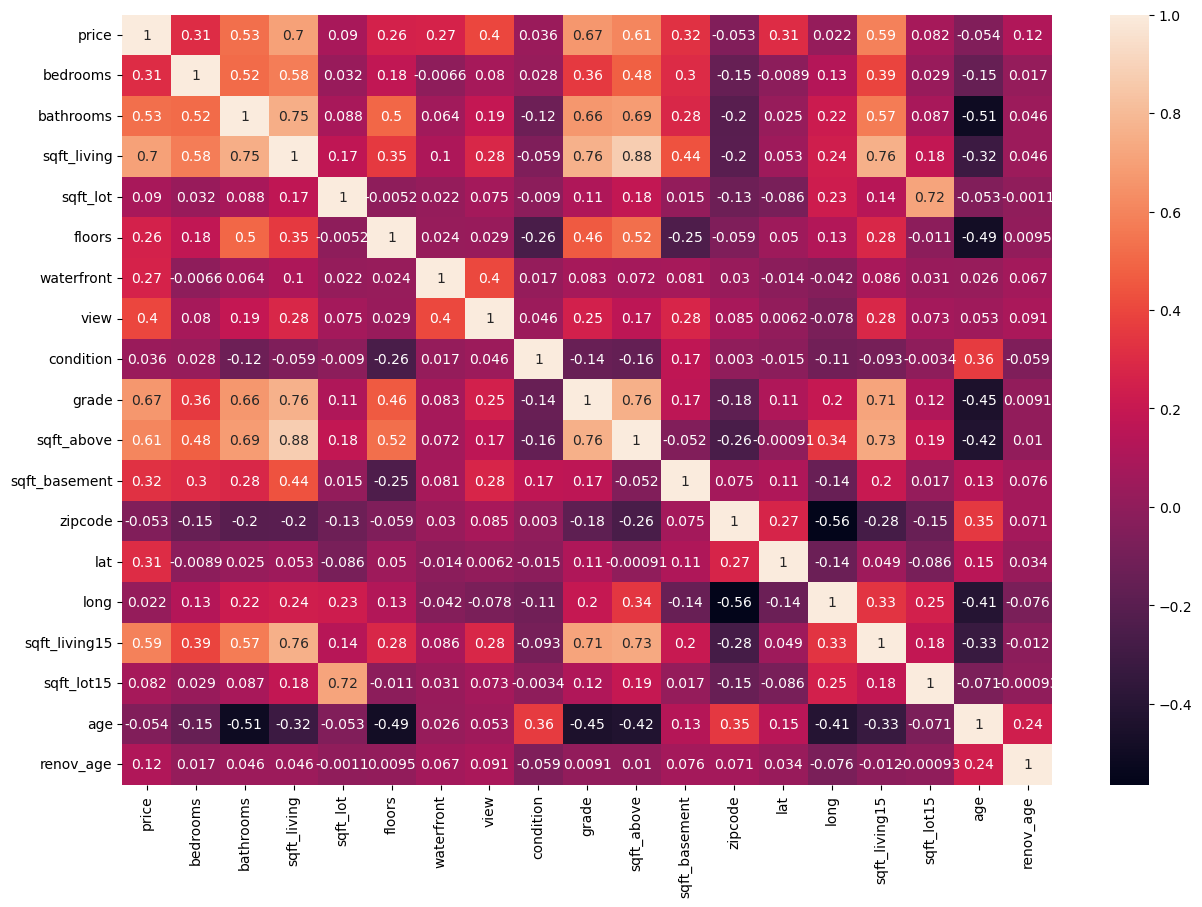

In [16]:
# plotting correlation heatmap
plt.figure(figsize=(15,10))
dataplot = sns.heatmap(data.corr(), annot=True)

# displaying heatmap
plt.show()

In [17]:
for i , r in data.corr().iterrows():
  print(i)

price
bedrooms
bathrooms
sqft_living
sqft_lot
floors
waterfront
view
condition
grade
sqft_above
sqft_basement
zipcode
lat
long
sqft_living15
sqft_lot15
age
renov_age


In [18]:
for i , r in data.corr().iterrows():
  print(r)

price            1.000000
bedrooms         0.308350
bathrooms        0.525138
sqft_living      0.702035
sqft_lot         0.089661
floors           0.256794
waterfront       0.266369
view             0.397293
condition        0.036362
grade            0.667434
sqft_above       0.605416
sqft_basement    0.323816
zipcode         -0.053203
lat              0.307003
long             0.021626
sqft_living15    0.585379
sqft_lot15       0.082447
age             -0.054012
renov_age        0.117200
Name: price, dtype: float64
price            0.308350
bedrooms         1.000000
bathrooms        0.515884
sqft_living      0.576671
sqft_lot         0.031703
floors           0.175429
waterfront      -0.006582
view             0.079532
condition        0.028472
grade            0.356967
sqft_above       0.477479
sqft_basement    0.303093
zipcode         -0.152668
lat             -0.008931
long             0.129473
sqft_living15    0.391638
sqft_lot15       0.029244
age             -0.154178
renov_age 

In [19]:
#print highly correlated variables
corr_features =[]

for i , r in data.corr().iterrows():
    k=0 #counter
    for j in range(len(r)):
        if i!= r.index[k]:
            if r.values[k] >=0.5:
                corr_features.append([i, r.index[k], r.values[k]])
        k += 1
corr_features

[['price', 'bathrooms', 0.5251375054139628],
 ['price', 'sqft_living', 0.7020350546118005],
 ['price', 'grade', 0.6674342560202353],
 ['price', 'sqft_above', 0.6054162591641183],
 ['price', 'sqft_living15', 0.5853789035795692],
 ['bedrooms', 'bathrooms', 0.5158836376158312],
 ['bedrooms', 'sqft_living', 0.5766706925022448],
 ['bathrooms', 'price', 0.5251375054139628],
 ['bathrooms', 'bedrooms', 0.5158836376158312],
 ['bathrooms', 'sqft_living', 0.7546652789673752],
 ['bathrooms', 'floors', 0.5006531725878688],
 ['bathrooms', 'grade', 0.6649825338780723],
 ['bathrooms', 'sqft_above', 0.6852729704767271],
 ['bathrooms', 'sqft_living15', 0.568634289578226],
 ['sqft_living', 'price', 0.7020350546118005],
 ['sqft_living', 'bedrooms', 0.5766706925022448],
 ['sqft_living', 'bathrooms', 0.7546652789673752],
 ['sqft_living', 'grade', 0.7627044764584776],
 ['sqft_living', 'sqft_above', 0.8762879508115581],
 ['sqft_living', 'sqft_living15', 0.7564202590172237],
 ['sqft_lot', 'sqft_lot15', 0.71855

In [20]:
# remove highly correlated features that is above 0.8
feat =[]
for i in corr_features:
    if i[2] >= 0.8: # 2 is the correlation value as it is shown in the corr_features output above
        feat.append(i[0])
        feat.append(i[1])

data.drop(list(set(feat)), axis=1, inplace=True)

## **Outlier Detection**

Price Feature Before Dealing With Outliers

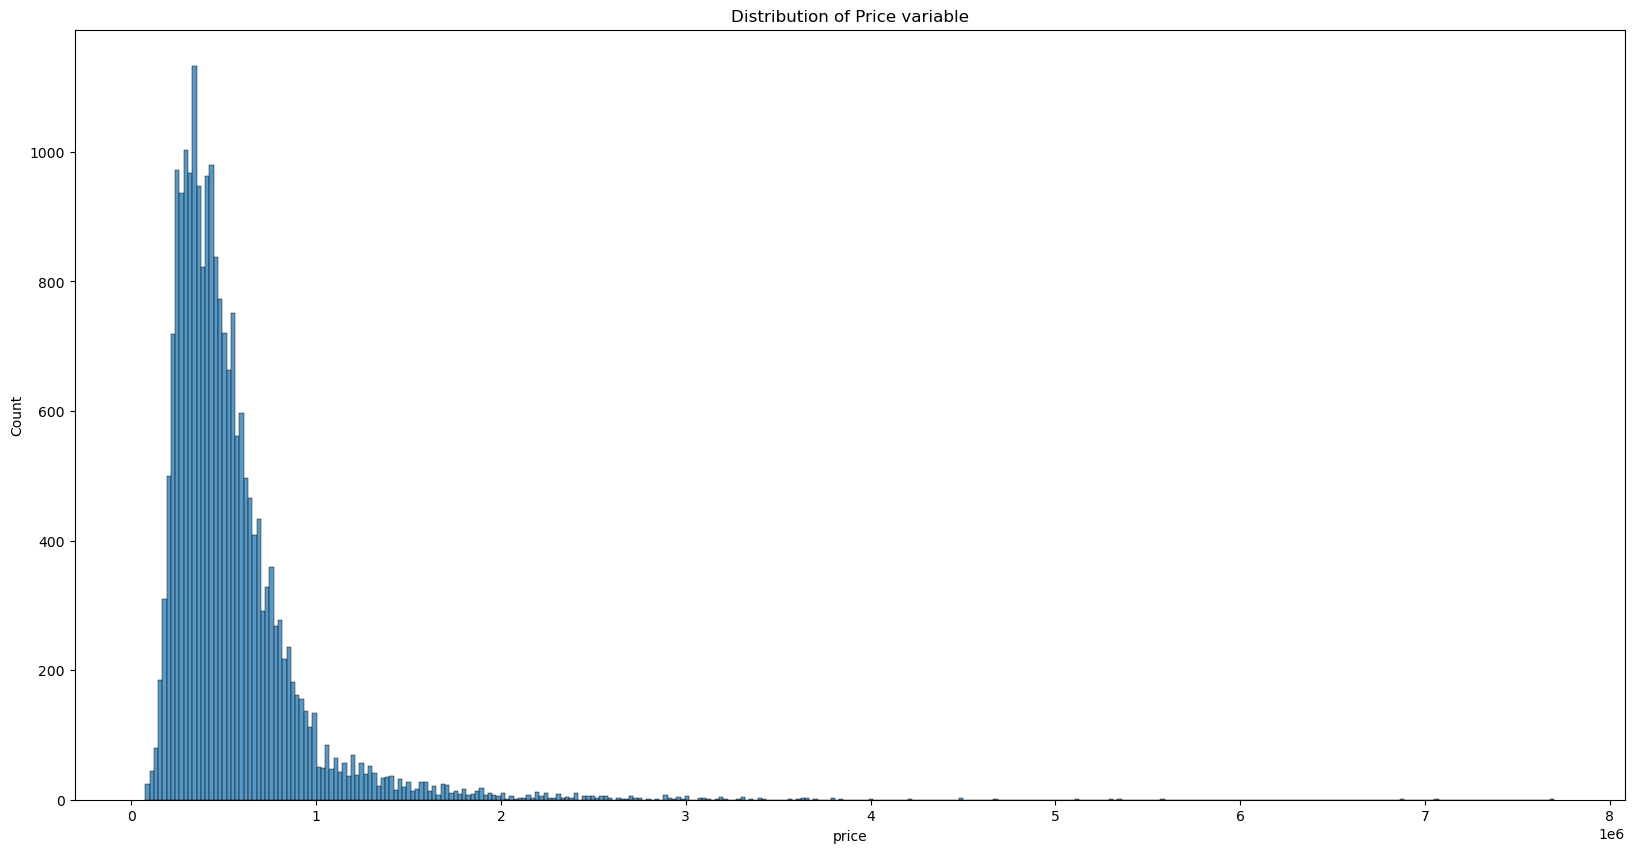

In [23]:

#plot the (dependent) variable to see its distribution
# plt.title()
plt.figure(figsize=(20,10))
sns.histplot(data.price, kde=False).set_title('Distribution of Price variable')
plt.show()

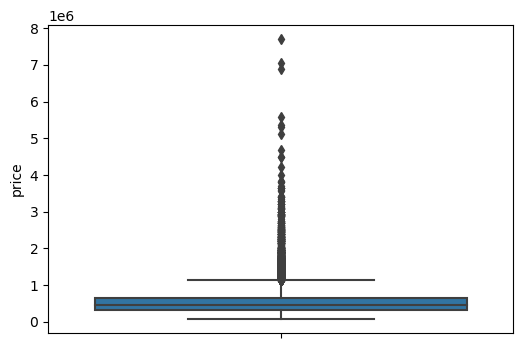

In [24]:
# creating boxplots to see the outliers in the price variable

plt.figure(figsize=(6,4))
sns.boxplot(y=data['price'])
plt.show()

#### Using Interquartile Range

In [25]:
#let us numerically draw conclusions
#creating function that can calculate interquartile range of the data
def calc_interquartile(data, column):
    global lower, upper
    #calculating the first and third quartile
    first_quartile, third_quartile = np.percentile(data[column], 25), np.percentile(data[column], 75)
    #calculate the interquartilerange
    iqr = third_quartile - first_quartile
    # outlier cutoff (1.5 is a generally taken as a threshold)
    cutoff = iqr*1.5
    #calculate the lower and upper limits
    lower, upper = first_quartile - cutoff , third_quartile + cutoff
    #remove the outliers from the columns
    upper_outliers = data[data[column] > upper]
    lower_outliers = data[data[column] < lower]
    print('Lower outliers', lower_outliers.shape[0])
    print('Upper outliers', upper_outliers.shape[0])
    return print('total outliers', upper_outliers.shape[0] + lower_outliers.shape[0])

Lower outliers 0
Upper outliers 1146
total outliers 1146
1129575.0 -162625.0


/var/folders/8j/5mg1hqbx0rxgbv5q60g_dhhc0000gn/T/ipykernel_2137/2648419974.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['price'], kde=False)


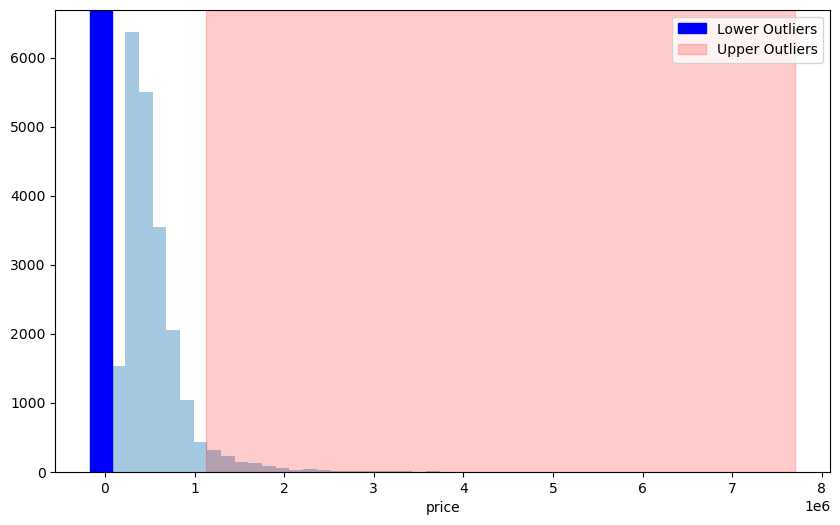

In [26]:
#plotting outliers graph for 'price' feature
calc_interquartile(data, 'price')
plt.figure(figsize = (10,6))
sns.distplot(data['price'], kde=False)
print(upper, lower)
plt.axvspan(xmin = lower,xmax= data['price'].min(),alpha=1, color='blue', label='Lower Outliers')
plt.axvspan(xmin = upper,xmax= data['price'].max(),alpha=0.2, color='red', label='Upper Outliers')
plt.legend()
plt.show()

#### Using ZScore

In [27]:
""" creating function for calculating zscore which is subtracting the mean from every data point and dividing by the standard deviation and if the zscore value of any data point
is less than -3 or greater than 3, then that data point is an outlier"""

# from scipy.stats import zscore

def z_score(data, column):
    #creating global variables for plotting the graph for better demonstration
    global zscore, outlier
    #creating lists to store zscore and outliers
    zscore = []
    outlier =[]
    # for zscore generally taken thresholds are 2.5, 3 or 3.5 hence i took 3
    threshold = 3
    # calculating the mean of the passed column
    mean = np.mean(data[column])
    # calculating the standard deviation of the passed column
    std = np.std(data[column])
    for i in data[column]:
        z = (i-mean)/std
        zscore.append(z)
        #if the zscore is greater than threshold = 3 that means it is an outlier
        if np.abs(z) > threshold:
            outlier.append(i)
    return print('total outliers', len(outlier))

total outliers 406


/var/folders/8j/5mg1hqbx0rxgbv5q60g_dhhc0000gn/T/ipykernel_2137/1978760055.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(zscore, kde=False)


1129575.0 -162625.0


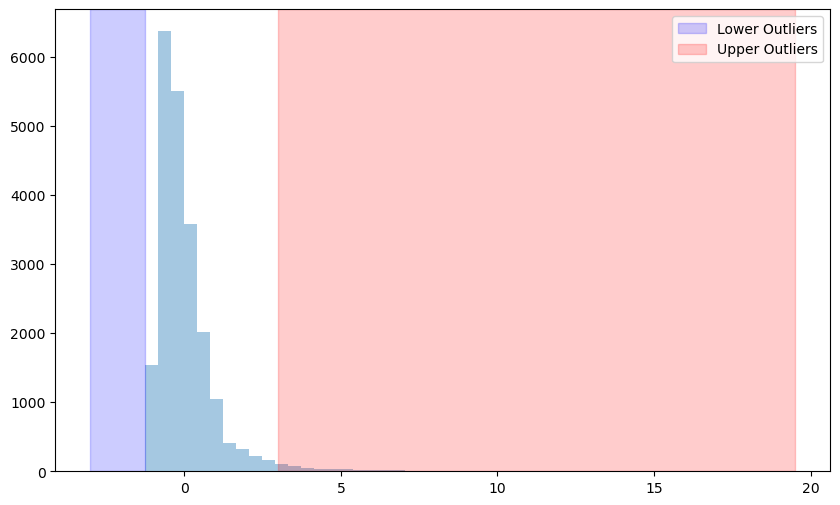

In [28]:
#plotting outliers graph for 'price' feature
z_score(data, 'price')
plt.figure(figsize = (10,6))
sns.distplot(zscore, kde=False)
print(upper, lower)
plt.axvspan(xmin = -3 ,xmax= min(zscore),alpha=0.2, color='blue', label='Lower Outliers')
plt.axvspan(xmin = 3 ,xmax= max(zscore),alpha=0.2, color='red', label='Upper Outliers')
plt.legend()
plt.show()

In [29]:
#remove the outliers from price using zscore
dj=[]
for i in data.price:
    if i in set(outlier):
        dj.append(0.0)
    else:
        dj.append(i)

data['P'] = dj

x = data.drop(data[data['P'] == 0.0].index)
x.shape

(21207, 18)

/var/folders/8j/5mg1hqbx0rxgbv5q60g_dhhc0000gn/T/ipykernel_2137/2913199190.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x['price'], kde=False)


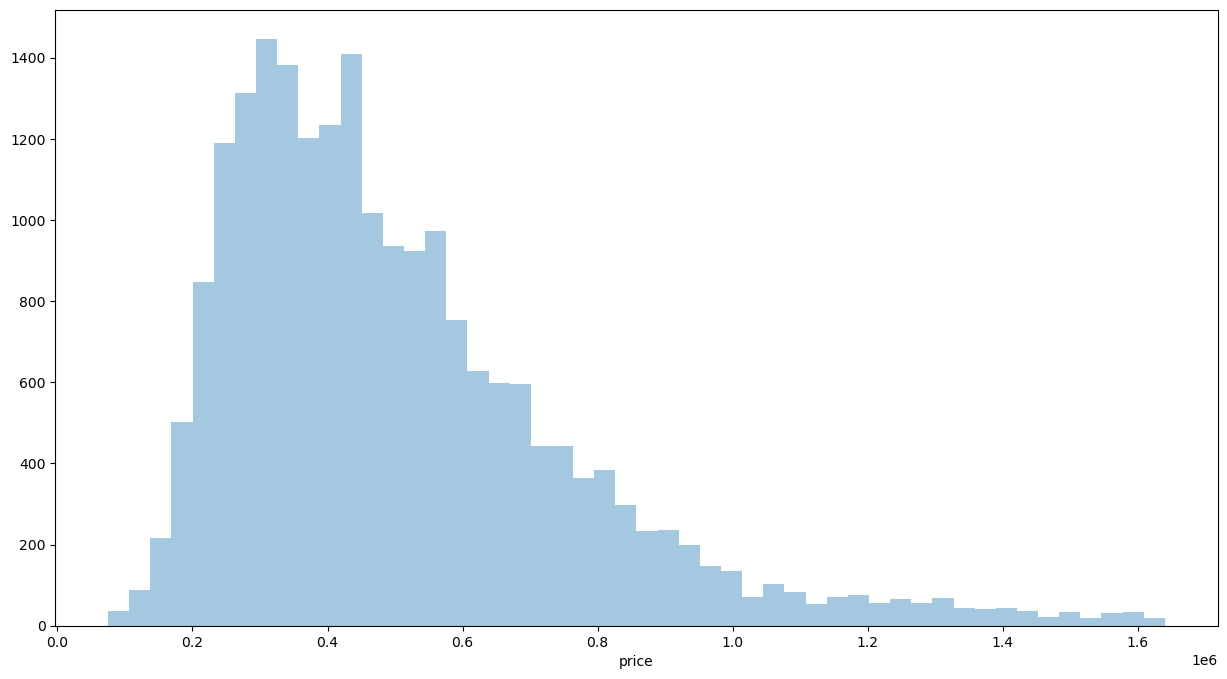

In [30]:
plt.figure(figsize = (15,8))
sns.distplot(x['price'], kde=False)
plt.show()

Comparing the data

In [31]:
#isolation forest
import warnings
warnings.filterwarnings(action='ignore')
from sklearn.ensemble import IsolationForest
iso = IsolationForest()
outlier = iso.fit_predict(data)

In [ ]:
outlier

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
print(set(outlier))

{1, -1}


-1 for outliers, 1 for non-outliers

In [ ]:
#mask variable contains all the outliers
mask = outlier == -1
#task variable contains all the non-outliers data
task = outlier == 1
#creating dataframe containing outliers
df_1 = data[mask]
#creating dataframe containing non-outliers
df_2 = data[task]

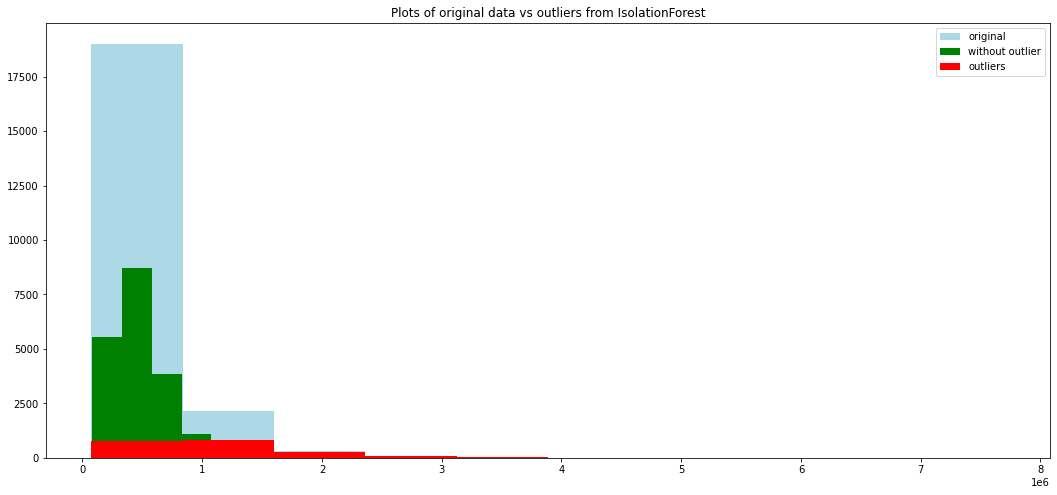

In [ ]:
#plotting graph to show the original data, outliers and non-outliers
plt.figure(figsize=(18, 8))
plt.title('Plots of original data vs outliers from IsolationForest')
plt.hist(data['price'], label= 'original', color='lightblue')
plt.hist(df_2['price'], label='without outlier', color='green')
plt.hist(df_1['price'], label='outliers', color='red')
plt.legend()
plt.show()

##**Model Building**

In [ ]:
#defining the independent and dependent variable
X = x.drop(['price','P'], axis=1) #independent varaibles
Y = x['price'] #dependent variable

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state=42)
lr = LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
r2_score(y_test, pred)

0.6917485447465683

###**Creating Pipeline for all models**

In [ ]:
sc = ('Scaler', StandardScaler())
est =[]
est.append(('LinearRegression', Pipeline([sc, ('LinearRegression', LinearRegression())])))
est.append(('Ridge', Pipeline([sc, ('Ridge', Ridge())])))
est.append(('Lasso', Pipeline([sc, ('Lasso', Lasso())])))
est.append(('BayesianRidge', Pipeline([sc, ('BayesianRidge', BayesianRidge())])))
est.append(('ElasticNet', Pipeline([sc,('Elastic', ElasticNet())])))
est.append(('SGD', Pipeline([sc,('SGD', SGDRegressor())])))
est.append(('Huber', Pipeline([sc,('Huber', HuberRegressor())])))
est.append(('RANSAC', Pipeline([sc,('RANSAC', RANSACRegressor())])))
est.append(('GradientBoosting', Pipeline([sc,('GradientBoosting',GradientBoostingRegressor())])))
est.append(('AdaBoost', Pipeline([sc, ('AdaBoost', AdaBoostRegressor())])))
est.append(('ExtraTree', Pipeline([sc,('ExtraTrees', ExtraTreesRegressor())])))
est.append(('RandomForest', Pipeline([sc,('RandomForest', RandomForestRegressor())])))
est.append(('Bagging', Pipeline([sc,('Bagging', BaggingRegressor())])))
est.append(('KNeighbors', Pipeline([sc,('KNeighbors', KNeighborsRegressor())])))
est.append(('DecisionTree', Pipeline([sc,('DecisionTree', DecisionTreeRegressor())])))
est.append(('XGB', Pipeline([sc,('XGB', XGBRegressor())])))

In [ ]:
# using KFold cross validation
import warnings
warnings.filterwarnings(action='ignore')
seed = 4
splits = 7
score = 'r2'
models_score =[]
for i in est:
    kfold = KFold(n_splits=splits, random_state=seed, shuffle=True)
    results = cross_val_score(i[1], x_train, y_train, cv=kfold, scoring=score)
    models_score.append({i[0] : '{}'.format(results.mean())})

[04:49:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[04:49:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
models_score

[{'LinearRegression': '0.6051185072742342'},
 {'Ridge': '0.6051186922715839'},
 {'Lasso': '0.6051185258409818'},
 {'BayesianRidge': '0.6051194092434848'},
 {'ElasticNet': '0.5501122694481356'},
 {'SGD': '0.6044891894319965'},
 {'Huber': '0.6003343240956742'},
 {'RANSAC': '0.4873795938528364'},
 {'GradientBoosting': '0.7599320183544173'},
 {'AdaBoost': '0.3947811064237354'},
 {'ExtraTree': '0.7489626633577496'},
 {'RandomForest': '0.7755587832151665'},
 {'Bagging': '0.7535903440906441'},
 {'KNeighbors': '0.6424188946681761'},
 {'DecisionTree': '0.5601529410166883'},
 {'XGB': '0.759882787923888'}]

results might vary when run it at different times.

###**Hyperparameter Tuning**

In [ ]:
#Tuning only XGB as it has the higher accuracy
est =[]
est.append(('XGB', Pipeline([sc,('XGB', XGBRegressor())])))

best = []

parameters = {

              'XGB': {'XGB__learning_rate': [0.1,0.2,0.3,0.4],

                         'XGB__max_depth': [4,6,8],
                      'XGB__n_estimators': [100,500,1000,1500]}
             }

for i in est:
    kfold = KFold(n_splits=5, random_state=seed, shuffle=True)
    grid = GridSearchCV(estimator=i[1], param_grid = parameters[i[0]], cv = kfold, n_jobs=-1)
    grid.fit(x_train, y_train)
    best.append((i[0], grid.best_score_,  grid.best_params_))

In [ ]:
#implementing it with best parameters
xgb = XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=1000)
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)
xgb.score(x_test,y_test)

[02:19:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8733764163860631

In [ ]:
x_train

,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,renov_age
2610,3.0,2.50,30886.0,2.0,0.0,0.0,3.0,8.0,0.0,98045.0,47.4600,-121.707,1740.0,39133.0,22.0,0.0
17502,3.0,2.50,71002.0,1.0,0.0,0.0,4.0,9.0,0.0,98022.0,47.2689,-122.010,3170.0,84000.0,18.0,0.0
15475,2.0,1.50,7200.0,1.0,0.0,0.0,3.0,7.0,0.0,98199.0,47.6490,-122.403,1550.0,6000.0,104.0,77.0
10195,5.0,3.50,4800.0,2.0,0.0,2.0,3.0,8.0,760.0,98118.0,47.5592,-122.269,2080.0,4900.0,96.0,65.0
2514,4.0,2.50,4736.0,2.0,0.0,0.0,3.0,7.0,0.0,98053.0,47.6869,-122.036,2690.0,4791.0,13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11471,5.0,2.25,16553.0,2.0,0.0,2.0,5.0,9.0,800.0,98040.0,47.5428,-122.236,3690.0,17916.0,46.0,0.0
12161,3.0,1.75,39639.0,1.0,0.0,0.0,4.0,8.0,0.0,98075.0,47.5929,-121.989,2330.0,30492.0,38.0,16.0
5482,4.0,2.50,6605.0,2.0,0.0,0.0,3.0,8.0,680.0,98011.0,47.7498,-122.181,2730.0,5962.0,25.0,0.0
873,4.0,2.50,10514.0,2.0,0.0,0.0,3.0,10.0,0.0,98074.0,47.6323,-122.036,2820.0,11462.0,31.0,0.0


## **Feature Selection**

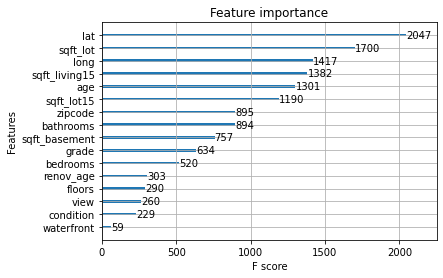

In [ ]:
from xgboost import plot_importance
plot_importance(xgb)
plt.show()

I will use the top 9 features as my final fetaures to build my model and deploy it. I can also consider all these important features shown above.
NB: **Lat** and **Long** are very important features in this regard. They are telling us that the location of the building is an important factor in determining the price or value of the property. The zip code is also telling us the same thing. In this example, I will omit the **Lat** and **Long** because if i do the deployment and I want people to check the value of their property, it is mostly difficult for them to provide the exact latitude and logitute of their property. In reality, I would have gone extra mile to collect extra data on the location of the properties or houses and add that data to my dataset which i can use to build my model instead of using latitude and longitude.

I will rather include the **zipcode** which also tells us the location of the houses.

In [ ]:
x

,price,bedrooms,bathrooms,sqft_lot,floors,waterfront,view,condition,grade,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,age,renov_age,P
0,221900.0,3.0,1.00,5650.0,1.0,0.0,0.0,3.0,7.0,0.0,98178.0,47.5112,-122.257,1340.0,5650.0,59.0,0.0,221900.0
1,538000.0,3.0,2.25,7242.0,2.0,0.0,0.0,3.0,7.0,400.0,98125.0,47.7210,-122.319,1690.0,7639.0,63.0,40.0,538000.0
2,180000.0,2.0,1.00,10000.0,1.0,0.0,0.0,3.0,6.0,0.0,98028.0,47.7379,-122.233,2720.0,8062.0,82.0,0.0,180000.0
3,604000.0,4.0,3.00,5000.0,1.0,0.0,0.0,5.0,7.0,910.0,98136.0,47.5208,-122.393,1360.0,5000.0,49.0,0.0,604000.0
4,510000.0,3.0,2.00,8080.0,1.0,0.0,0.0,3.0,8.0,0.0,98074.0,47.6168,-122.045,1800.0,7503.0,28.0,0.0,510000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3.0,2.50,1131.0,3.0,0.0,0.0,3.0,8.0,0.0,98103.0,47.6993,-122.346,1530.0,1509.0,5.0,0.0,360000.0
21609,400000.0,4.0,2.50,5813.0,2.0,0.0,0.0,3.0,8.0,0.0,98146.0,47.5107,-122.362,1830.0,7200.0,1.0,0.0,400000.0
21610,402101.0,2.0,0.75,1350.0,2.0,0.0,0.0,3.0,7.0,0.0,98144.0,47.5944,-122.299,1020.0,2007.0,5.0,0.0,402101.0
21611,400000.0,3.0,2.50,2388.0,2.0,0.0,0.0,3.0,8.0,0.0,98027.0,47.5345,-122.069,1410.0,1287.0,11.0,0.0,400000.0


In [ ]:
Y #Y contains only the price

0        221900.0
1        538000.0
2        180000.0
3        604000.0
4        510000.0
           ...   
21608    360000.0
21609    400000.0
21610    402101.0
21611    400000.0
21612    325000.0
Name: price, Length: 21207, dtype: float64

In [ ]:
SelectedFeatures = x[['sqft_lot','sqft_living15','age','zipcode','bathrooms','bedrooms','renov_age','sqft_basement','grade']]
SelectedFeatures

,sqft_lot,sqft_living15,age,zipcode,bathrooms,bedrooms,renov_age,sqft_basement,grade
0,5650.0,1340.0,59.0,98178.0,1.00,3.0,0.0,0.0,7.0
1,7242.0,1690.0,63.0,98125.0,2.25,3.0,40.0,400.0,7.0
2,10000.0,2720.0,82.0,98028.0,1.00,2.0,0.0,0.0,6.0
3,5000.0,1360.0,49.0,98136.0,3.00,4.0,0.0,910.0,7.0
4,8080.0,1800.0,28.0,98074.0,2.00,3.0,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...
21608,1131.0,1530.0,5.0,98103.0,2.50,3.0,0.0,0.0,8.0
21609,5813.0,1830.0,1.0,98146.0,2.50,4.0,0.0,0.0,8.0
21610,1350.0,1020.0,5.0,98144.0,0.75,2.0,0.0,0.0,7.0
21611,2388.0,1410.0,11.0,98027.0,2.50,3.0,0.0,0.0,8.0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(SelectedFeatures, Y, test_size = 0.3, random_state=42)

#implementing it with best parameters
xgb = XGBRegressor(learning_rate=0.1, max_depth=4, n_estimators=1000)
xgb.fit(x_train, y_train)
pred = xgb.predict(x_test)
xgb.score(x_test,y_test)


[02:19:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.8346848971893831

In [ ]:
lr=LinearRegression()
lr.fit(x_train, y_train)
pred = lr.predict(x_test)
lr.score(x_test,y_test)

0.5935645159913372

In [ ]:
import pickle

# Creating a pickle file for the classifier
pickle.dump(xgb, open('model.pkl', 'wb'))